In [1]:
import numpy as np
import pandas as pd
from openpyxl import load_workbook
import re
import QuantLib as ql
from scipy.interpolate import interp2d
from collections import namedtuple, OrderedDict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook

In [2]:
file = 'C:/Users/rstrepparava/Documents/Projects_2018/AU_Teaching/HW_CallableBonds/CallableBond.xlsx'
wb = load_workbook(filename=file, read_only=False, data_only=True)

### 0. Utility Functions

In [3]:
def load_workbook_range(range_string, ws):
    col_start, col_end = re.findall("[A-Z]+", range_string)

    data_rows = []
    for row in ws[range_string]:
        data_rows.append([cell.value for cell in row])

    return pd.DataFrame(data_rows[1:], columns=data_rows[0])
    #from openpyxl.utils import get_column_interval
    #return pd.DataFrame(data_rows, columns=get_column_interval(col_start, col_end))    

In [4]:
def convert_date(date):
    return(ql.Date(date.day, date.month, date.year))

In [5]:
def plot_curves(*curves):
    %matplotlib notebook
    fig, ax = plt.subplots()
    ax.set_xlim(0,15)
    ax.set_xticks([0,5,10,15])
    times = np.linspace(0.0, 15.0, 400)
    for curve, style in curves:
        rates = [ curve.zeroRate(t, ql.Continuous).rate() for t in times ]
        plt.plot(times, rates, style)
        plt.xlabel('tenor (Yrs)')
        plt.ylabel('rate')


def plot_curve(curve):
    plot_curves((curve,'-'))

In [6]:
d={'1Mo': 1/12, '3Mo': 3/12, '6Mo': 6/12, '9Mo': 9/12, 
   '1Yr': 1, '2Yr': 2, '3Yr': 3, '4Yr': 4, '5Yr': 5,
   '6Yr': 6, '7Yr': 7, '8Yr': 8, '9Yr': 9, '10Yr': 10,
   '12Yr': 12, '15Yr': 15, '20Yr': 20, '25Yr': 25, '30Yr': 30}

In [7]:
def plot_surface(surf_df):
    %matplotlib notebook
    ## DataFrame from 1D-arrays
    surf = surf_df.stack().reset_index()
    x = surf.iloc[:, 0]
    y = surf.iloc[:, 1]
    z = surf.iloc[:, 2]
    df = pd.DataFrame({'x': x, 'y': y, 'z': z}, index=range(len(x)))

    fig = plt.figure()
    ax = Axes3D(fig)
    # Plot using `.trisurf()`:
    ax.plot_trisurf(df.x, df.y, df.z, cmap=cm.coolwarm, edgecolor='none', linewidth=0.2)
    ax.set_xlabel('Option tenor')
    ax.set_ylabel('Swap tenor')
    ax.set_zlabel('ATM Normal Volatility')
    #cmap='viridis'
    #plt.show()

In [8]:
def interp(surf_df):
    surf = surf_df.stack().reset_index()
    x = surf.iloc[:, 0]
    y = surf.iloc[:, 1]
    z = surf.iloc[:, 2]
    return interp2d(x, y, z, kind='linear')

In [9]:
def create_swaption_helpers(data, index, term_structure, engine):
    '''Implement function missing from guide
    '''
    # based on
    # http://khandrikacm.blogspot.ch/2014/03/european-style-interest-rate-swaption.html
    nominal = 1.0
    fixed_leg_tenor = ql.Period(6, ql.Months)
    fixed_leg_daycounter = ql.Thirty360()
    floating_leg_daycounter = ql.Actual360()
    
    swaptions = [ql.SwaptionHelper(ql.Period(swap.start, ql.Years),
                                   ql.Period(swap.length, ql.Years),
                                   ql.QuoteHandle(ql.SimpleQuote(swap.volatility)),
                                   #/\
                                   #term_structure.forwardRate(swap.start, swap.start+swap.length, 
                                   #                           ql.Continuous).rate())),
                                   index, 
                                   fixed_leg_tenor,
                                   fixed_leg_daycounter, 
                                   floating_leg_daycounter,
                                   term_structure,
                                   ql.CalibrationHelper.RelativePriceError) for swap in data]
                                   #ql.nullDouble(),
                                   #nominal,
                                   #voltype,
                                   #displacement) for swap in data]
    for swap in swaptions:
        swap.setPricingEngine(engine)
    return swaptions

In [10]:
def calibration_report(swaptions, data):
    cal_report = OrderedDict()
    for ix, swap in enumerate(swaptions):
        swaprep = OrderedDict()
        swaprep['Model Price'] = swap.modelValue()
        swaprep['Market Price'] = swap.marketValue()
        swaprep['Abs Error Price'] = swap.marketValue()-swap.modelValue()
        swaprep['Rel Error Price'] = (swap.modelValue()-swap.marketValue())/swap.marketValue()
        swaprep['Implied Vol'] = swap.impliedVolatility(swap.modelValue(),
                                                        0.01, 1000, 0.001, 0.9)
        swaprep['Market Vol'] = data[ix].volatility
        swaprep['Abs Error Vol'] = swaprep['Implied Vol'] - swaprep['Market Vol']
        swaprep['Rel Error Vol'] = (swaprep['Implied Vol'] - swaprep['Market Vol'])/swaprep['Market Vol']
        cal_report[(data[ix].start, data[ix].length,
                    data[ix].volatility)] = swaprep
    cal_report = pd.DataFrame(cal_report).T
    print("Cumulative Error : %15.5f" % np.sqrt((cal_report['Rel Error Vol']**2).sum())) 
    return cal_report

### 1. Setup dates and calendars

In [11]:
issue      = ql.Date(10, ql.September, 2015)
valuation  = ql.Date(31, ql.March, 2017)
maturity   = ql.Date(10, ql.September, 2045)
first_call = ql.Date(10, ql.September, 2020)
cpn_freq   = 1
call_freq  = 1
dayCounterCurve = ql.Actual360()
dayCounterBond  = ql.Thirty360(ql.Thirty360.BondBasis)
bizdayconv = ql.ModifiedFollowing
calendar   = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
ql.Settings.instance().evaluationDate = valuation

### 2. Setup Curve and Volatility Surface 

<IPython.core.display.Javascript object>


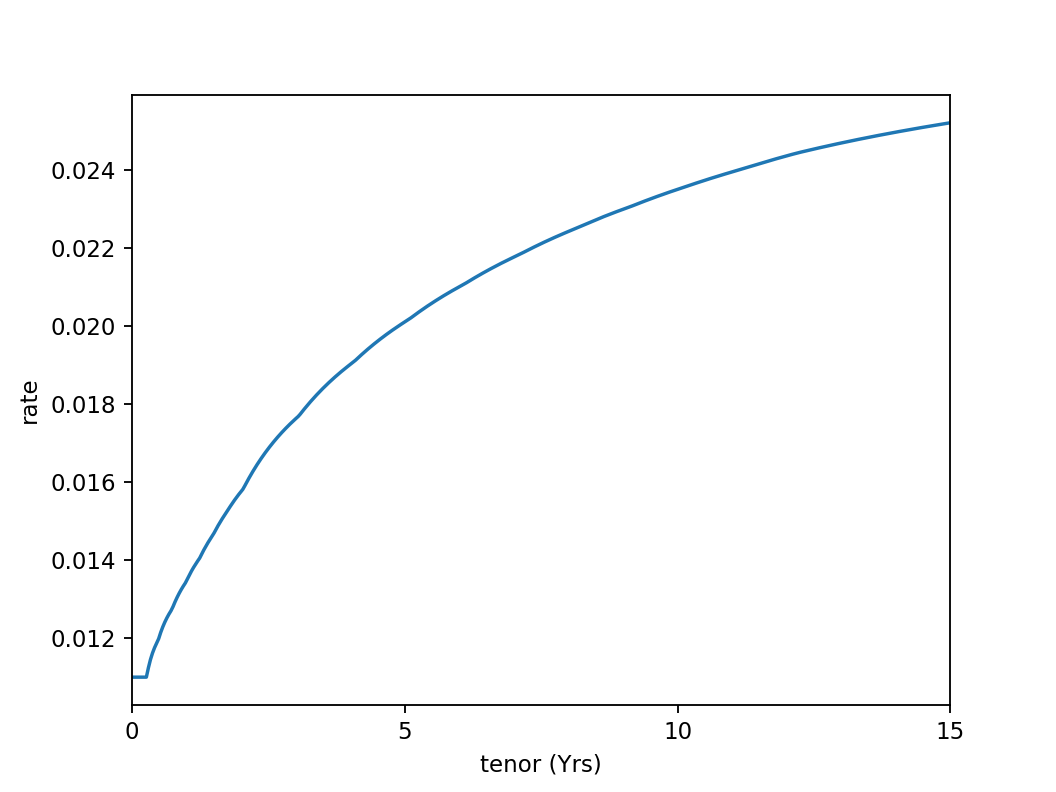

In [12]:
ws = wb['Market Data']

discount_df = load_workbook_range('B19:C44', ws)
discount_df.set_index(keys='DATE', drop=True, inplace=True)
discount_df.dropna(inplace=True)

YC = ql.YieldTermStructureHandle(ql.DiscountCurve(discount_df.index.map(lambda x: convert_date(x)),
                                                  discount_df['DISCOUNT FACTOR'].values,
                                                  dayCounterCurve))
plot_curve(YC)

<IPython.core.display.Javascript object>


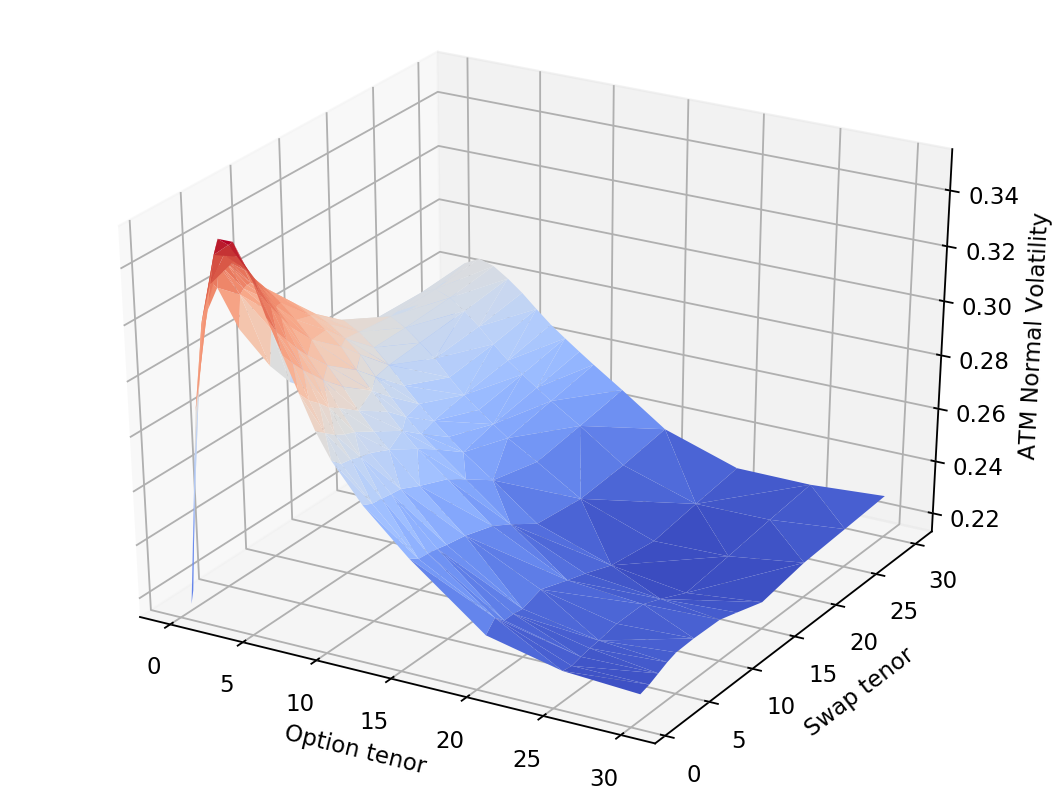

In [13]:
VOLSF = load_workbook_range('I2:U21', ws)
VOLSF.set_index(keys='VOL.MATRIX', drop=True, inplace=True)
VOLSF.dropna(inplace=True)
VOLSF = VOLSF / 10000 # Normal volatiltiy in NumeriX in bps
VOLSF.columns = VOLSF.columns.map(lambda x: int(x[:-2]))
VOLSF.index = VOLSF.index.map(lambda x: d[x])

# this version of Quantlib does not handle Bachelier normal volatility, hence
# we will use the crude approximation sigmaATM_LN = sigmaATM_N / F valid only when T -> 0

for t in VOLSF.index:
    for T in VOLSF.columns:
        VOLSF.loc[t, T] = VOLSF.loc[t, T] / YC.forwardRate(t, t+T, ql.Continuous, 
                                                           ql.Annual, True).rate()

plot_surface(VOLSF)

### 3. Setup calibrating instruments (Swaptions)

In [14]:
index = ql.USDLibor(ql.Period(3, ql.Months),YC)

In [15]:
CalibrationData = namedtuple("CalibrationData", "start, length, volatility")
f = interp(VOLSF)
data = [CalibrationData(3, 25, f(3,25)[0]),
        CalibrationData(4, 24, f(4,24)[0]),
        CalibrationData(5, 23, f(5,23)[0]),
        CalibrationData(6, 22, f(6,22)[0]),
        CalibrationData(7, 21, f(7,21)[0]),
        CalibrationData(8, 20, f(8,20)[0]),
        CalibrationData(9, 19, f(9,19)[0]),
        CalibrationData(10, 18, f(10,18)[0]),
        CalibrationData(11, 17, f(11,17)[0]),
        CalibrationData(12, 16, f(12,16)[0]),
        CalibrationData(13, 15, f(13,15)[0]),
        CalibrationData(14, 14, f(14,14)[0]),
        CalibrationData(15, 13, f(15,13)[0]),
        CalibrationData(16, 12, f(16,12)[0]),
        CalibrationData(17, 11, f(17,11)[0]),
        CalibrationData(18, 10, f(18,10)[0]),
        CalibrationData(19, 9, f(19,9)[0]),
        CalibrationData(20, 8, f(20,8)[0]),
        CalibrationData(21, 7, f(21,7)[0]),
        CalibrationData(22, 6, f(22,6)[0]),
        CalibrationData(23, 5, f(23,5)[0]),
        CalibrationData(24, 4, f(24,4)[0]),
        CalibrationData(25, 3, f(25,3)[0]),
        CalibrationData(26, 2, f(26,2)[0]),
        CalibrationData(27, 1, f(27,1)[0])]

C:\ProgramData\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=20,15 m=228 fp=0.000001 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


### 4. Hull-White Calibration of Reversion Speed (lambda1) and  Volatility

In [16]:
#displacement = 0.
#voltype = ql.Normal
# displacement = 0.1
# voltype = ql.ShiftedLognormal

model = ql.HullWhite(YC);
engine = ql.JamshidianSwaptionEngine(model)
swaptions = create_swaption_helpers(data, index, YC, engine)

optimization_method = ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8)
end_criteria = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
model.calibrate(swaptions, optimization_method, end_criteria)

lambda1, sigma = model.params()
print("lambda1 = %6.5f, sigma = %6.5f" % (lambda1, sigma))
calibration_report(swaptions, data)

lambda1 = 0.02025, sigma = 0.00812
Cumulative Error :         0.48570


,,,Abs Error Price,Abs Error Vol,Implied Vol,Market Price,Market Vol,Model Price,Rel Error Price,Rel Error Vol
3,25,0.282551,0.014768,-0.045598,0.236953,0.091513,0.282551,0.076745,-0.161375,-0.161381
4,24,0.278306,0.015245,-0.042906,0.235400,0.098890,0.278306,0.083645,-0.154163,-0.154170
5,23,0.273153,0.014622,-0.038863,0.234289,0.102774,0.273153,0.088153,-0.142269,-0.142277
6,22,0.267091,0.013090,-0.033653,0.233438,0.103898,0.267091,0.090807,-0.125992,-0.126000
7,21,0.261380,0.011277,-0.028549,0.232832,0.103256,0.261380,0.091979,-0.109214,-0.109222
8,20,0.256527,0.009492,-0.023964,0.232563,0.101618,0.256527,0.092126,-0.093410,-0.093418
9,19,0.251593,0.007507,-0.019126,0.232467,0.098753,0.251593,0.091246,-0.076014,-0.076021
10,18,0.248827,0.006185,-0.016075,0.232753,0.095751,0.248827,0.089566,-0.064596,-0.064603
11,17,0.246877,0.005093,-0.013629,0.233248,0.092272,0.246877,0.087179,-0.055198,-0.055204
12,16,0.244520,0.003754,-0.010434,0.234086,0.087982,0.244520,0.084228,-0.042668,-0.042673


### 5. Hull-White Volatility Calibration with Fixed Reversion Speed

In [17]:
constrained_model = ql.HullWhite(YC, 0.03, 0.001);
engine = ql.JamshidianSwaptionEngine(constrained_model)
swaptions = create_swaption_helpers(data, index, YC, engine)

optimization_method = ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8)
end_criteria = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
constrained_model.calibrate(swaptions, optimization_method, end_criteria, ql.NoConstraint(), [], [True, False])

lambda1, sigma = model.params()
print("lambda1 = %6.5f, sigma = %6.5f" % (lambda1, sigma))
calibration_report(swaptions, data)

lambda1 = 0.02025, sigma = 0.00812
Cumulative Error :         0.49268


,,,Abs Error Price,Abs Error Vol,Implied Vol,Market Price,Market Vol,Model Price,Rel Error Price,Rel Error Vol
3,25,0.282551,0.014320,-0.044216,0.238335,0.091513,0.282551,0.077193,-0.156484,-0.156490
4,24,0.278306,0.014905,-0.041948,0.236358,0.098890,0.278306,0.083985,-0.150719,-0.150726
5,23,0.273153,0.014393,-0.038255,0.234898,0.102774,0.273153,0.088381,-0.140041,-0.140049
6,22,0.267091,0.012981,-0.033372,0.233719,0.103898,0.267091,0.090917,-0.124937,-0.124945
7,21,0.261380,0.011283,-0.028563,0.232817,0.103256,0.261380,0.091973,-0.109269,-0.109277
8,20,0.256527,0.009593,-0.024219,0.232307,0.101618,0.256527,0.092025,-0.094405,-0.094413
9,19,0.251593,0.007693,-0.019602,0.231991,0.098753,0.251593,0.091060,-0.077904,-0.077911
10,18,0.248827,0.006440,-0.016737,0.232091,0.095751,0.248827,0.089312,-0.067255,-0.067262
11,17,0.246877,0.005401,-0.014452,0.232425,0.092272,0.246877,0.086871,-0.058533,-0.058540
12,16,0.244520,0.004095,-0.011382,0.233138,0.087982,0.244520,0.083887,-0.046544,-0.046550


### 6. Callable Bond Pricing

In [18]:
callability_schedule = ql.CallabilitySchedule()
call_price = 100.0
call_date = first_call
for i in range(int(np.ceil((maturity - first_call)/365.25))):
    callability_price  = ql.CallabilityPrice(call_price, ql.CallabilityPrice.Clean)
    callability_schedule.append(ql.Callability(callability_price, ql.Callability.Call, call_date))
    call_date = calendar.advance(call_date, 1, ql.Years)

In [19]:
tenor = ql.Period(ql.Annual)
schedule = ql.Schedule(issue, maturity, tenor, calendar, bizdayconv, bizdayconv, 
                       ql.DateGeneration.Backward, False)

In [20]:
settlement_days = 3
face_amount = 100
coupon = 0.0425

bond = ql.CallableFixedRateBond(settlement_days, face_amount, schedule, [coupon], dayCounterBond,
                                bizdayconv, face_amount, issue, callability_schedule)

In [21]:
def value_bond(ts_handle, a, s, grid_points, bond):
    model = ql.HullWhite(ts_handle, a, s)
    engine = ql.TreeCallableFixedRateBondEngine(model, grid_points)
    bond.setPricingEngine(engine)
    return bond

In [46]:
b = value_bond(YC, lambda1, sigma, 40, bond)
print("Bond price: ",b.dirtyPrice())

Bond price:  106.67001515218413


### 7. NonCallable Bond Pricing

In [35]:
fixedschedule = ql.Schedule(issue, maturity, tenor, calendar, bizdayconv, bizdayconv, 
                            ql.DateGeneration.Backward, False)
fixedbond = ql.FixedRateBond(settlement_days, face_amount, fixedschedule,  [coupon], dayCounterBond)
bond_engine = ql.DiscountingBondEngine(YC)
fixedbond.setPricingEngine(bond_engine)
print("Bond price: ",fixedbond.dirtyPrice())

Bond price:  134.30324712745156


### 8. Price Compression for a Callable Bond vs. Non Callable

In [56]:
x = np.linspace(0.02, 0.07, 200)
call   = np.zeros(200) 
bullet = np.zeros(200)

for i, rate in enumerate(x):
    ts = ql.FlatForward(valuation, rate, dayCounterCurve, ql.Compounded, ql.Annual)
    ts_handle = ql.YieldTermStructureHandle(ts)    
    c = value_bond(ts_handle, lambda1, sigma, 200, bond)
    call[i] = c.dirtyPrice()
    bond_engine = ql.DiscountingBondEngine(ts_handle)
    fixedbond.setPricingEngine(bond_engine)
    bullet[i] = fixedbond.dirtyPrice()

<IPython.core.display.Javascript object>


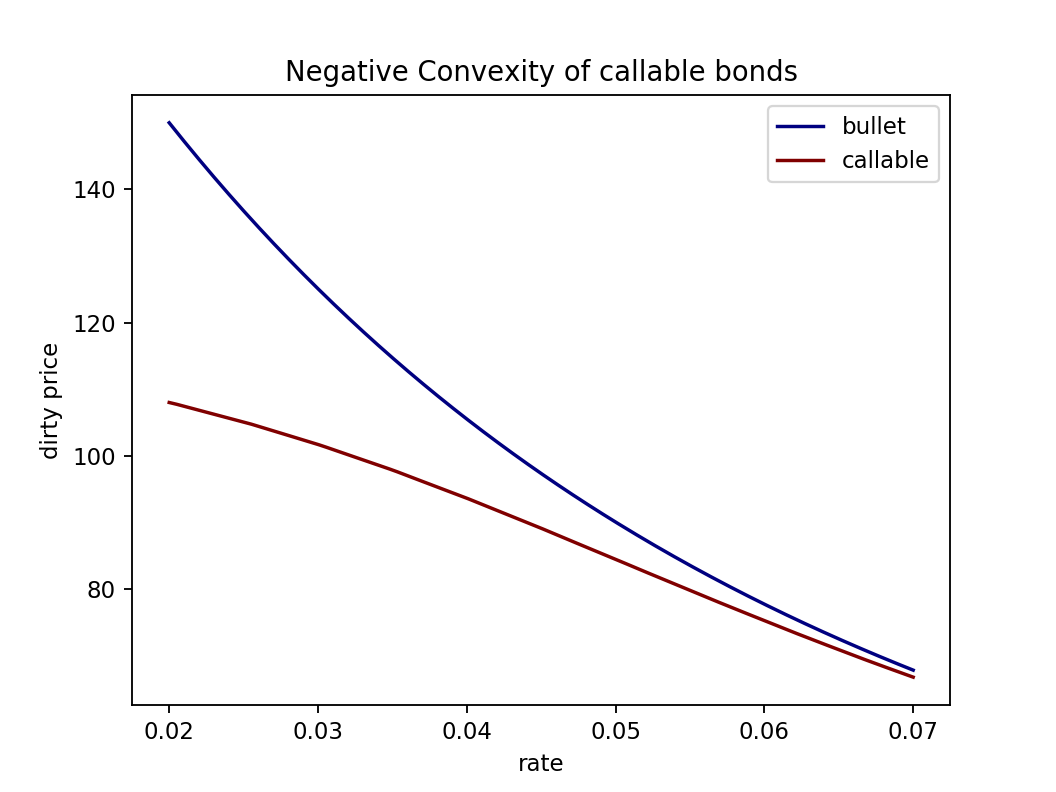

Text(0,0.5,'dirty price')

In [61]:
d = {'callable': call, 'bullet': bullet}
df = pd.DataFrame(data=d, index=x)
ax = df.plot(colormap='jet', markersize=10, title='Negative Convexity of callable bonds')
ax.set_xlabel('rate')
ax.set_ylabel('dirty price')